# Libraries

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import nltk
import tensorflow as tf
from tensorflow.keras import regularizers
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.activations import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

/Users/christinahailu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Read the posts and their labels

In [2]:
# Read the dataset
posts = pd.read_csv("Posts.txt", header=None)
labels = pd.read_csv("Labels.txt", header=None)
posts.columns = ['post']
labels.columns = ['labels']

labels = labels.replace('Free ', 'Free')  # Correcting labels with additional white space

# Check the length of sentences
## Concatenate the posts with their labels

In [3]:
# Add the number of words in each sentence as one feature
posts['Num_words'] = posts['post'].apply(lambda x:len(str(x).split()))
# Concatenate the posts with their labels to keep changes to come consistent
posts = pd.concat([posts, labels], axis=1)

# Check the existence of sentences with single words

In [4]:
# Extract sentence containing words with no spaces
single_words = posts['Num_words'] < 2
small_sentences = posts[single_words]
small_sentences.head()

,post,Num_words,labels
140,ዘርእየጠራንከምንወቃቀስሁሉምየጌታፍጥረቶችናቸውአሁንበቃንእንፀልይ,1,Free
334,ሰማእታት,1,Free
412,እግዚአብሄርሆይምረቱንላክልን,1,Free
806,ጋላየውገኑንብልእትቆርጦእናየብልእትቋንጣይዞየሜዞእርእሳርያልበላከብትእራሱጋ...,1,Free
833,እኔየሚገርመኝአሁንእድህየሚሆኑትምንለመሆንነዉ,1,Hate


In [5]:
# Not to be run, for checking the sentences with one word only
leng = []
one_word = []
for word in small_sentences['post']:
    leng.append(len(word))
    if len(word) < 10:
        one_word.append(word)

print(len(one_word))
longest = np.array(leng).max()

421


## Remove single word sentences

In [6]:
sentences = posts['Num_words'] > 1
dataset = posts[sentences]
print(dataset.shape)
dataset.head()

(29463, 3)


,post,Num_words,labels
0,አስቀድሜ ጥያቄዬ በጨዋነት በውስጥ መስመር እንዲደርስዎ አድርጌ ፍትህን ለ...,63,Free
1,እነዚህን ወሳኝ ጉዳዮችን የሚያስፈፅም አካል እንዲቋቋምና ክትትል እንዲደ...,10,Free
2,የአማራ ህዝብ በአእምሮ ክንፉ ያልበረረበት ጥበብና ፍልስፍና ያልከፈተው የ...,19,Free
3,ከአማራ ህዝብ የሀገሪቱ ዘርፈ ብዙ እውቀት መንጭቶ የሞላበትከሙላቱም በመል...,23,Free
4,ዛሬ በየትኛውም መለኪያ ይሁን መመዘኛ ኢትዮጵያዊነት የሚንፀባረቀው በአማራ...,25,Hate


## Examine or analyze the frequency or pattern of the number of words in sentences.

In [7]:
import pandas as pd
import plotly.express as px

# Assuming you have a DataFrame named 'dataset' containing the data

# Calculate the count of each value in the 'Num_words' column
plot_df = dataset.Num_words.value_counts().rename_axis('Num_words').reset_index(name='counts')

# Configure the color, appearance, and shape of the bars
fig = px.bar(plot_df, x="Num_words", y="counts", color="counts",
             title="Sentence Length Distribution",
             color_continuous_scale='viridis',  # Set the color scale
             template='plotly_dark',  # Set the plot template
             hover_data={'Num_words': True, 'counts': True},  # Include additional hover data
             labels={'Num_words': 'Number of Words', 'counts': 'Count'},  # Update axis labels
             width=800, height=500)  # Set the plot size

# Update the bar shapes
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))  # Update the bar line color and width

# Show the updated bar plot
fig.show()


This graph shows the distribution of sentence lengths in a dataset. The x-axis represents the number of words in a sentence, and the y-axis represents the count of sentences with that length. Each bar represents a specific sentence length, with the height indicating the number of sentences. The color of the bars represents the count, with darker colors indicating higher counts. This visualization helps understand the variation and patterns in sentence lengths within the dataset. The plot uses Plotly Express with a dark template and includes hover data for interactive exploration. The updated bar shapes have dark slate grey lines for better visibility.

## Downloaded file is included because they are not being viewed unless re-run every time opening the file. Please view "Plot-1.png" file. 

In [8]:
# Extract sentence containing words > 55
# 55 is set by observing the no. of sentences to lose by trial and error
many_words = dataset['Num_words'] > 55
large_sentences = dataset[many_words]
large_sentences

,post,Num_words,labels
0,አስቀድሜ ጥያቄዬ በጨዋነት በውስጥ መስመር እንዲደርስዎ አድርጌ ፍትህን ለ...,63,Free
282,ነፍስ ይማርልን ለወገኖቻችን እነዚህ ነፍሰበላ ደንቆሮ አህያነጅሁሉ ዋጋቸው...,94,Hate
467,ወንድሜ ታደለ ይሄን ጦማር ስትጦምር እያለቀስክ ሊሆን እንሚችል እገምታለሁ...,57,Free
576,ሞታቸው እጅግ ያማል ነገር ግን ለተፈጠረው ችግር ተጠያቂው መንግስት እንጅ...,63,Free
752,በተኮል ምናብ ቆመ ድንጋይ ይልቅ እናንተ የፈፀማቹት ግፍ እጅጉን ይልቃል ...,71,Hate
...,...,...,...
29113,የብሄራዊ እርቅና መግባባት ኮሚሽን ስራዉ ዉጤታማ መሆን ካለበት የዎቹ ትዉ...,66,Free
29655,ፖለቲካ አንዳች ነገር የማናዉቅ ነገር ግን ከእኛ በላይ ፖለቲካ ላሳር ነ...,110,Free
29666,በተለይ በተግደርዳሪ የፖለቲካ ሀይሎች ዘንድ ያለዉ ዝግጁነት እና የፖለቲካ...,63,Free
29743,ሚኪ በጣም ጥሩ ሀሳብ ነው ማንም ለ አማራ ህዝብ አስባለሁ የሚል አክቲቪስ...,58,Free


# Extract sentence of valuable word counts

In [9]:
max_length = 55
num_words = dataset['Num_words'] <= max_length
dataset = dataset[num_words]
dataset.shape

(28608, 3)

## Review or examine again the way in which the words are distributed

In [10]:
import pandas as pd
import plotly.express as px

# Assuming you have a DataFrame named 'dataset' containing the data

# Calculate the count of each value in the 'Num_words' column
plot_df = dataset.Num_words.value_counts().rename_axis('Num_words').reset_index(name='counts')

# Configure the color, appearance, and shape of the bars
fig = px.bar(plot_df, x="Num_words", y="counts", color="counts",
             title="Sentence Length Distribution",
             color_continuous_scale='viridis',  # Set the color scale
             template='plotly_dark',  # Set the plot template
             hover_data={'Num_words': True, 'counts': True},  # Include additional hover data
             labels={'Num_words': 'Number of Words', 'counts': 'Count'},  # Update axis labels
             width=800, height=500)  # Set the plot size

# Update the bar shapes
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))  # Update the bar line color and width

# Show the updated bar plot
fig.show()


This graph shows the distribution of sentence lengths in a dataset. The x-axis represents the number of words in a sentence, and the y-axis represents the count of sentences with that length. Each bar represents a specific sentence length, with the height indicating the number of sentences. The color of the bars represents the count, with darker colors indicating higher counts. This visualization helps understand the variation and patterns in sentence lengths within the dataset. The plot uses Plotly Express with a dark template and includes hover data for interactive exploration. The updated bar shapes have dark slate grey lines for better visibility.

## Downloaded file is included because they are not being viewed unless re-run every time opening the file. Please view "Plot-2.png" file. 

In [11]:
post = dataset['post'].values
label = dataset['labels'].values

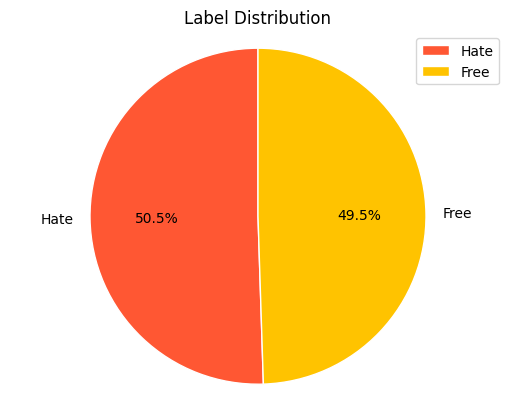

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'dataset' containing the data

# Count the occurrences of each label
label_counts = dataset['labels'].value_counts()

# Define custom colors
colors = ['#FF5733', '#FFC300', '#DAF7A6', '#C70039']  # Different custom colors

# Create the pie chart
plt.pie(label_counts, labels=label_counts.index, colors=colors, autopct='%1.1f%%',
        startangle=90, wedgeprops={'edgecolor': 'white'})

# Set the aspect ratio to be equal to create a circular pie chart
plt.axis('equal')

# Add a title and legend to the chart
plt.title('Label Distribution')
plt.legend(label_counts.index, loc='best')

# Display the chart
plt.show()

This pie chart illustrates the distribution of labels in a dataset. Each slice represents a unique label, and its size corresponds to the proportion of occurrences for that label. Custom colors are used for visual distinction, and the percentage of occurrences is displayed on each slice. The chart is displayed in a circular shape with an equal aspect ratio. The title "Label Distribution" and a legend provide context and label mapping, respectively. This graph serves as a visual summary of the label distribution, enabling quick understanding of the relative frequencies of different labels in the dataset.

In [13]:
# Tokenize the sentences and encode them into sequence of integers
vocab_size = 102000
tokenizer = Tokenizer()
tokenizer = Tokenizer(num_words=vocab_size, oov_token="unk")
tokenizer.fit_on_texts(post)

print(str(tokenizer.texts_to_sequences(['እነዚህን ወሳኝ ጉዳዮችን የሚያስፈፅም አካል እንዲቋቋምና ክትትል እንዲደረግ በመግለጫው ጠይቀዋል'])))

[[754, 707, 3360, 5255, 359, 7232, 4127, 3588, 4422, 6422]]


In [14]:
# Padding to sentences having words less than 55
data = np.array(tokenizer.texts_to_sequences(post), dtype=object)
data = pad_sequences(data, padding='post', maxlen=max_length)

# Train-validation-test split and encoding

In [16]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size = 0.10, random_state = 42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.10, random_state = 42)

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [17]:
# Check the sizes of the train-validation and test data
print(len(train_labels))
print(len(valid_labels))
print(len(test_labels))

23172
2575
2861


# Model Building

In [30]:
model = tf.keras.Sequential()
model.add(Embedding(vocab_size +1, 100, input_length=max_length,
                    embeddings_regularizer = regularizers.l2(0.0005)))
model.add(Conv1D(128,3, activation='relu',
                 kernel_regularizer = regularizers.l2(0.0005),
                 bias_regularizer = regularizers.l2(0.0005)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid',
                kernel_regularizer=regularizers.l2(0.001),
                bias_regularizer=regularizers.l2(0.001),))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 55, 100)           10200100  
                                                                 
 conv1d_1 (Conv1D)           (None, 53, 128)           38528     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 10238886 (39.06 MB)
Trainable params: 10238886 (39.06 MB)
Non-trainable params: 0 (0.00 Byte)
____________

# Train the model

In [31]:
history = model.fit(train_ds.shuffle(2000).batch(128), epochs= 10,
                    validation_data=valid_ds.batch(128), verbose=1)

Epoch 1/10
182/182 [==============================] - 11s 57ms/step - loss: 1.0720 - accuracy: 0.5668 - val_loss: 0.6918 - val_accuracy: 0.6179
Epoch 2/10
182/182 [==============================] - 11s 59ms/step - loss: 0.7026 - accuracy: 0.6329 - val_loss: 0.7080 - val_accuracy: 0.6450
Epoch 3/10
182/182 [==============================] - 10s 55ms/step - loss: 0.7033 - accuracy: 0.6706 - val_loss: 0.7330 - val_accuracy: 0.6509
Epoch 4/10
182/182 [==============================] - 11s 58ms/step - loss: 0.6961 - accuracy: 0.7131 - val_loss: 0.7671 - val_accuracy: 0.6544
Epoch 5/10
182/182 [==============================] - 11s 58ms/step - loss: 0.6730 - accuracy: 0.7650 - val_loss: 0.8188 - val_accuracy: 0.6629
Epoch 6/10
182/182 [==============================] - 11s 60ms/step - loss: 0.6381 - accuracy: 0.8212 - val_loss: 0.8758 - val_accuracy: 0.6586
Epoch 7/10
182/182 [==============================] - 11s 60ms/step - loss: 0.5957 - accuracy: 0.8657 - val_loss: 0.9380 - val_accuracy:

# Test the model

In [32]:
# A function to decode back the encoded labels
def label_decode(le, one_hot_label):
    return le.inverse_transform(one_hot_label)

print("Generate predictions for test sets.")
predictions = model.predict(x_test).argmax(axis=1)
predicted = label_decode(le, predictions)
print(predicted)

Generate predictions for test sets.
90/90 [==============================] - 0s 2ms/step
['Free' 'Free' 'Free' ... 'Hate' 'Free' 'Hate']


In [33]:
y_test

array(['Hate', 'Free', 'Hate', ..., 'Hate', 'Free', 'Hate'], dtype=object)

# Confusion Matrix and Classification Report

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['Hate', 'Free']
print(classification_report(y_test, predicted))
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_test, predicted), index=labels, columns=labels)

              precision    recall  f1-score   support

        Free       0.66      0.61      0.63      1388
        Hate       0.66      0.71      0.68      1473

    accuracy                           0.66      2861
   macro avg       0.66      0.66      0.66      2861
weighted avg       0.66      0.66      0.66      2861

Confusion Matrix


,Hate,Free
Hate,841,547
Free,430,1043


# Loss and Accuracy curves

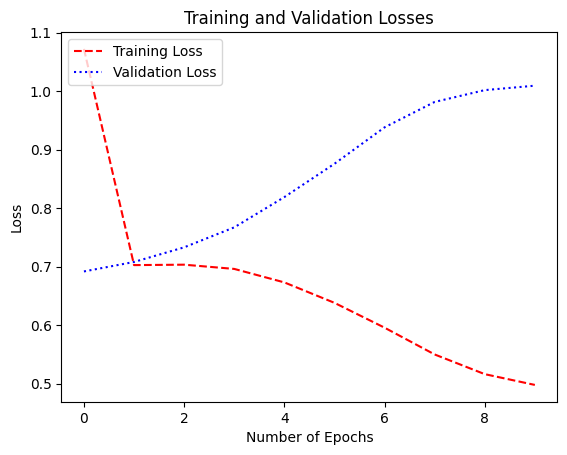

In [35]:
import matplotlib.pyplot as plt

# Assuming you have the history object containing training and validation loss

plt.plot(history.history['loss'], label='Training Loss', color='red', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue', linestyle=':')
plt.title('Training and Validation Losses')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(loc='upper left')
plt.show()

This graph shows the training and validation losses during model training. The x-axis represents the number of epochs, and the y-axis represents the loss. The blue line represents the training loss, which decreases as the model learns from the training data. The orange line represents the validation loss, which measures the model's performance on unseen data. The goal is to minimize both losses. If the validation loss is high compared to the training loss, it indicates potential overfitting. This graph helps assess the model's progress and generalization ability.

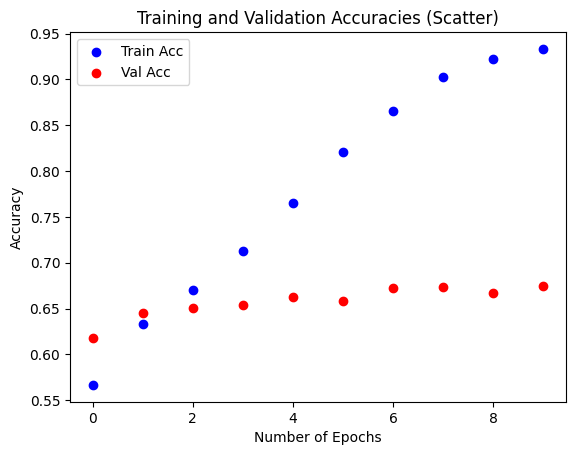

In [36]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracies as scatter plots
plt.scatter(range(len(history.history['accuracy'])), history.history['accuracy'], color='blue', label='Train Acc')
plt.scatter(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], color='red', label='Val Acc')

# Set the title, labels, and legend
plt.title('Training and Validation Accuracies (Scatter)')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Show the plot
plt.show()

This graph depicts the training and validation accuracies of a machine learning model over various epochs. The blue line represents training accuracy, indicating how well the model performs on the training data, while the orange line represents validation accuracy, reflecting performance on unseen validation data. Comparing the two accuracies helps identify overfitting (a large gap between training and validation accuracies) or underfitting (both accuracies are low). This information guides adjustments to hyperparameters or regularization techniques to improve the model's performance.

# End

In [38]:
import joblib 

joblib.dump({'model': model, 'tokenizer': tokenizer}, 'Hate_Speech_Detection.pkl')


['Hate_Speech_Detection.pkl']